# Character-level nanoGPT

This is an experiment in training a tiny transformer on character-level data. It's based on a port of nanoGPT — [see the model docs for details](src/experiment/model/README.md).

Initially, this experiment was run in a Kaggle notebook. When porting it to run in Modal instead, it started to become hard to work with. The port didn't make it significantly more complicated, but a few things needed to be refactored to run well remotely. So now most of the code lives in modules under [`src/experiment`](src/experiment), and this notebook just ties it together in an way that makes it easy to play with.

In [1]:
import logging

from utils.logging import concise_logging

concise_logging()
logging.getLogger('experiment').setLevel(logging.INFO)
logging.getLogger('utils').setLevel(logging.INFO)

In [2]:
from torch.nn import CrossEntropyLoss

from experiment.config import DataConfig, ModelConfig, OptimizerConfig, SchedulerConfig, TokenizerConfig, TrainingConfig

config = TrainingConfig(
    model=ModelConfig(
        vocab_size=64,  # dummy value, will be set after loading the dataset
        block_size=512,
        n_embd=32,
        n_head=8,
        n_head_dim=8,
        n_ff=128,
        n_layer=15,
        dropout=0.2,
    ),
    tokenizer=TokenizerConfig(
        vocabulary=[],  # dummy value, will be set after loading the dataset
    ),
    data=DataConfig(
        batch_size=8,
        oversample=1,
        train_split=0.8,
    ),
    optimizer=OptimizerConfig(
        weight_decay=1e-1,
        learning_rate=0,
        betas=(0.9, 0.95),
    ),
    scheduler=SchedulerConfig(
        epochs=100,
        warmup_epochs=1,
        min_lr_factor=0.1,
        decay_strategy="cosine",
    ),
)

criterion = CrossEntropyLoss()

Prepare for remote execution. Technically we don't need to pre-build the image, but doing so makes the output of later cells cleaner.

In [3]:
import modal
from experiment.compute.app import data_dir
from utils.requirements import freeze

app_name = "nanogpt-rope"

image = (
    modal.Image.debian_slim()
    .pip_install(*freeze(all=True, local=False))
    .add_local_python_source('experiment', 'utils')
)  # fmt: skip

volume = modal.Volume.from_name(app_name, create_if_missing=True)

app = modal.App(app_name, image=image, volumes={data_dir: volume})


@app.function()
def prebuild():
    """Forces the image to be built."""
    pass


with app.run():
    prebuild.remote()

I 1.9 u.r:     Selected 58 of 101 dependencies


# Data

We'll grab a small dataset. It's just one big block of text from which we take random substrings. These may overlap, but we aim to take roughly the entire corpus on each epoch.

Of note: the "labels" $y$ are the same as the input values $x$, shifted by one, since we want to predict each next token.

```python
x = self.data[idx:idx + self.block_size]
y = self.data[idx + 1:idx + self.block_size + 1]
```

In [4]:
import ftfy
import requests

from experiment.config import DatasetMetadata
from utils.param_types import validate_call


@validate_call(validate_return=True)
def download_the_scarlet_pimpernel() -> tuple[str, DatasetMetadata]:
    url = "https://www.gutenberg.org/cache/epub/60/pg60.txt"
    response = requests.get(url)
    response.raise_for_status()
    text = response.text.replace("\r\n", "\n")
    text = text[text.find("\nCHAPTER I.") : text.rfind("*** END OF THE PROJECT GUTENBERG EBOOK")].strip()
    # Normalize text to avoid weird quotation marks etc.
    text, explanation = ftfy.fix_and_explain(text)
    metadata = DatasetMetadata(
        title="The Scarlet Pimpernel",
        url=url,
        fixes=explanation,
        total_chars=len(text),
        vocab_size=len(set(text)),
    )
    return text, metadata

In [5]:
from experiment.compute.data_pipelines import save_data
from experiment.data.preparation import tokenize_data
from experiment.utils import align
from utils.modal import run


@app.function()
def prepare_data():
    sources = [
        download_the_scarlet_pimpernel(),
    ]
    data, metadata = tokenize_data(sources)
    save_data(data, metadata)
    volume.commit()
    return metadata


async with run(app):
    input_metadata = await prepare_data.remote.aio()

config.tokenizer = input_metadata.tokenizer_config.model_copy()
config.model.vocab_size = align(config.tokenizer.vocab_size, 64)
input_metadata.model_dump(exclude=["tokenizer_config"])

{'total_tokens': 485190,
 'total_chars': 485190,
 'sources': [{'title': 'The Scarlet Pimpernel',
   'author': None,
   'url': 'https://www.gutenberg.org/cache/epub/60/pg60.txt',
   'fixes': [('apply', 'uncurl_quotes')],
   'total_chars': 485190,
   'language': None}]}

# Training


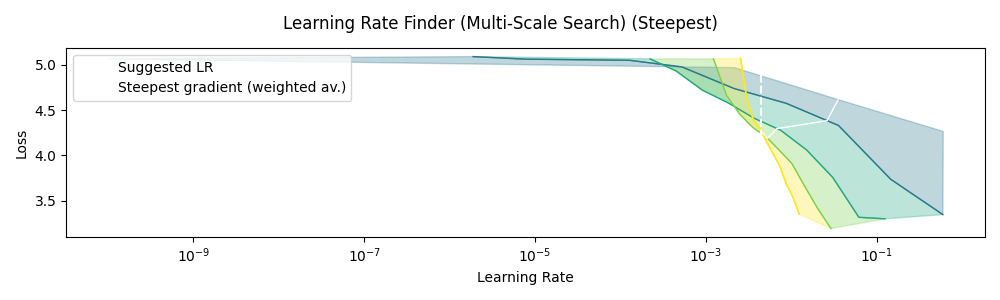

Initializing GPT model with config: vocab_size=128 block_size=512 n_embd=32 n_head=8 n_head_dim=8 n_ff=128 n_layer=15 dropout=0.2
number of parameters: 0.26M
Progress: 2% - {'zoom': 0, 'step': 1}
Progress: 4% - {'zoom': 0, 'step': 2}
Progress: 6% - {'zoom': 0, 'step': 3}
Progress: 8% - {'zoom': 0, 'step': 4}
Progress: 10% - {'zoom': 0, 'step': 5}
Progress: 12% - {'zoom': 0, 'step': 6}
Progress: 14% - {'zoom': 0, 'step': 7}
Progress: 16% - {'zoom': 0, 'step': 8}
Progress: 18% - {'zoom': 0, 'step': 9}
Progress: 20% - {'zoom': 1}
Progress: 20% - {'zoom': 1, 'step': 0}
Progress: 22% - {'zoom': 1, 'step': 1}
Progress: 24% - {'zoom': 1, 'step': 2}
Progress: 26% - {'zoom': 1, 'step': 3}
Progress: 28% - {'zoom': 1, 'step': 4}
Progress: 30% - {'zoom': 1, 'step': 5}
Progress: 32% - {'zoom': 1, 'step': 6}
Progress: 34% - {'zoom': 1, 'step': 7}
Progress: 36% - {'zoom': 1, 'step': 8}
Progress: 38% - {'zoom': 1, 'step': 9}
Progress: 40% - {'zoom': 2}
Progress: 40% - {'zoom': 2, 'step': 0}
Progress: 

In [6]:
import torch
from experiment.compute.data_pipelines import load_data
from experiment.data.dataloader import get_dataloader
from experiment.model.gpt import GPT
from experiment.training.optimizer import configure_optimizer
from utils.lr_finder.lr_finder import lr_finder_search
from utils.lr_finder.types import LRFinderConfig, LRFinderSeries, Progress
from utils.lr_finder.vis import lr_finder_plot
from utils.modal import SyncHandler, send_to
from utils.param_types import validate_call


@app.function(gpu="T4")
@validate_call
def find_learning_rate(plot: SyncHandler[LRFinderConfig | LRFinderSeries], prog: SyncHandler[Progress]):
    model = GPT(config.model)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = configure_optimizer(model, config.optimizer)
    data, _ = load_data()

    if torch.cuda.is_available():
        data = data.cuda()
        model = model.cuda()
        criterion = criterion.cuda()

    train_loader, _ = get_dataloader(data, model_config=config.model, data_config=config.data)

    for event in lr_finder_search(model, criterion, optimizer, train_loader):
        match event:
            case LRFinderConfig() | LRFinderSeries() as data:
                plot(data)
            case Progress() as progress:
                prog(progress)
            case float() as suggested_lr:
                return suggested_lr
    raise ValueError("No suggested learning rate found.")


@validate_call(validate_return=True)
def progress() -> SyncHandler[Progress]:
    total_steps = 1

    @validate_call
    def _progress(event: Progress):
        nonlocal total_steps
        if event.total_steps:
            total_steps = event.total_steps
        suffix = f" - {event.info}" if event.info else ""
        if event.step:
            fraction = event.step / total_steps
            print(f"Progress: {fraction:.0%}{suffix}")

    return _progress


async with run(app), send_to(lr_finder_plot()) as plot, send_to(progress()) as prog:
    suggested_lr = await find_learning_rate.remote.aio(plot, prog)

print(f"Suggested Learning Rate: {suggested_lr:.2e}")
config.optimizer.learning_rate = suggested_lr

In [7]:
from contextlib import asynccontextmanager
from typing import AsyncGenerator

from tqdm.auto import tqdm

from experiment.compute.model import save_checkpoint
from experiment.compute.training import TrainingEvent, train_model
from utils.modal import SyncHandler, send_to


@app.function(gpu="T4")
def train(emit: SyncHandler[TrainingEvent]):
    for event in train_model(config):
        match event:
            case "checkpoint", (model, cfg, metrics):
                save_checkpoint(model, cfg, metrics)
                volume.commit()
            case _:
                emit(event)


@asynccontextmanager
async def progress() -> AsyncGenerator[SyncHandler[TrainingEvent]]:
    with (
        # loss_chart(epochs) as plot,
        tqdm(total=0, desc="Epoch") as pb_epoch,
        tqdm(total=0, desc="Step", leave=False) as pb_step,
    ):

        def progress_callback(event: TrainingEvent):
            match event:
                case "epochs", total:
                    pb_epoch.total = total
                    pb_epoch.refresh()
                case "steps-per-epoch", total:
                    pb_step.total = total
                    pb_step.refresh()
                case ("train-step", n) | ("val-step", n):
                    pb_step.update(n)
                case "epoch-end", metrics:
                    pb_epoch.set_postfix(metrics.model_dump())
                    pb_epoch.update(1)
                    # plot(metrics.val_loss)

        yield progress_callback


async with run(app), progress() as prog_cb, send_to(prog_cb) as emit:
    await train.remote.aio(emit=emit)

/workspaces/ai-research/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch: 0it [00:00, ?it/s]

Initializing GPT model with config: vocab_size=128 block_size=512 n_embd=32 n_head=8 n_head_dim=8 n_ff=128 n_layer=15 dropout=0.2
number of parameters: 0.26M
Traceback (most recent call last):
  File "/pkg/modal/_runtime/container_io_manager.py", line 728, in handle_input_exception
    yield
  File "/pkg/modal/_container_entrypoint.py", line 240, in run_input_sync
    res = io_context.call_finalized_function()
  File "/pkg/modal/_runtime/container_io_manager.py", line 180, in call_finalized_function
    res = self.finalized_function.callable(*args, **kwargs)
  File "/tmp/ipykernel_83137/4192729683.py", line 13, in train
  File "/root/experiment/compute/training.py", line 37, in train_model
    scheduler = configure_scheduler(optimizer, config.scheduler, epoch_length=len(train_loader))
  File "/root/experiment/training/scheduler.py", line 16, in configure_scheduler
    start_factor=config.start_factor,
                 ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.13/site-packages/

Epoch: 0it [00:11, ?it/s]


Stopping app - uncaught exception raised in remote container: AttributeError("'SchedulerConfig' object has no attribute 'start_factor'").


AttributeError: 'SchedulerConfig' object has no attribute 'start_factor'

# Generate continuations

In [ ]:
from pydantic import NonNegativeFloat, PositiveInt
from experiment.compute.model import load_checkpoint
from experiment.data.tokenizer import CharTokenizer


@app.function()
@validate_call(validate_return=True)
def generate(
    prompts: list[str],
    max_new_tokens: PositiveInt,
    temperature: NonNegativeFloat,
) -> tuple[list[list[str]], torch.Tensor]:
    print("Loading model from checkpoint")
    model, config, _ = load_checkpoint()
    model.eval()
    tokenizer = CharTokenizer(config.tokenizer)
    context: torch.Tensor = tokenizer.encode(prompts, target="tensor")
    if torch.cuda.is_available():
        context = context.cuda()
        model = model.cuda()

    print(f"Generating {max_new_tokens} tokens with temperature {temperature}")
    output = model.generate(context, max_new_tokens=max_new_tokens, temperature=temperature).cpu()
    print(f"Generated {len(output.tokens)} tokens")

    return tokenizer.decode_each(output.tokens), output

In [ ]:
prompts = ["Odd's fish m'dear,"]

with app.run():
    generation, metadata = generate.remote(prompts=prompts, max_new_tokens=500, temperature=0.5)

for sequence in generation:
    print(sequence[:40], "(etc.)")

Odd's fish m'dear, with the own to see o (etc.)


### Token metrics: Perplexity and entropy

Let's visualize the generation along with some metrics:
* **Entropy** is how diffuse the probability distribution is for the next token, i.e. the spread of probabilities before sampling. Can be thought of as how uncertain the model is about what to say next. This usually isn't calculated for prompt tokens.
* **Perplexity** is how unlikely the next token is. Can be thought of as how surprised the model is by the presence of the token at this point in the sequence. This is usually calculated for prompt tokens, but can also be calculated for continuation tokens.

```python
# For entropy (uncertainty about next token):
probs = F.softmax(next_token_logits, dim=-1)
entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)

# For perplexity (surprise about actual token):
token_loss = F.cross_entropy(next_token_logits, idx_next.view(-1), reduction='none')
perplexities[curr_len] = torch.exp(token_loss)
```

Notably, _the entropy of continuation tokens is unaffected by temperature_, whereas the perplexity _is_ affected (because it's calculated after sampling).

We should expect them to be correlated, because when the model is very certain (low entropy), it's more likely to sample a high-probability token (low perplexity), and vice-versa. But they can diverge in interesting ways: You could have high entropy but still sample a high-probability token by chance (high entropy, low perplexity), or You could have low entropy but sample an unlikely token due to temperature (low entropy, high perplexity).

In [ ]:
from utils import text_metrics_vis

viz = text_metrics_vis(chars_per_line=80, vocab_size=config.tokenizer.vocab_size)
viz.visualize(generation, metadata.surprisal, metadata.entropy)

# Future research

### Temperature as a resource

It's interesting to note that the first character of each word is high entropy and high perplexity, and subsequent characters are lower. And where the model makes spelling mistakes, it often had low entropy but then high perplexity! Which suggests that it knows what it wants to write, but the sampling mechanism is messing it up.

I'd like to see if it improves to lower the temperature after the first letter of each word. How would that generalise to languages that don't use spaces? Perhaps the temperature could be a resource that gets used (by picking unlikely tokens) and gradually replenished (by picking likely ones). Yeah that could be really cool!

# References

Karpathy, A. (2022). nanoGPT [Computer software]. GitHub. https://github.com/karpathy/nanoGPT

Sanderson, G. (2024a). Visualizing attention, a transformer's heart. 3Blue1Brown. https://www.3blue1brown.com/lessons/attention

Sanderson, G. (2024b). How might LLMs store facts. 3Blue1Brown. https://www.3blue1brown.com/lessons/mlp

# Software Licenses

The code in this notebook is derived from nanoGPT (Karpathy, 2022), which is licensed under the MIT License, Copyright (c) 2022 Andrej Karpathy.